In [3]:
import sys
sys.path.append('/home/kyungtak.lim/gbspy')

import gbspy as g
import numpy as np
import matplotlib.pyplot as plt
import os
import h5py

import multiprocessing as mp
from matplotlib.animation import FuncAnimation
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from matplotlib.ticker import AutoMinorLocator
import matplotlib.lines as mlines
from matplotlib.ticker import AutoMinorLocator

# Get the current working directory|
cwd = os.getcwd()

In [35]:
os.chdir('/zhisongqu_data/kyungtak/data_GBS/GBS_SN/nu_scan/SN_nu1')
s=g.Sim()

t_final = s.time[-1]
t_init = t_final -1

tempe = s.get_field('temperature', t1=t_init, t2=t_final)
dens = s.get_field('n', t1=t_init, t2=t_final)

tempe_avg = np.mean(tempe, axis=(2,3))
dens_avg  = np.mean(dens, axis=(2,3)); 


In [38]:
dens.shape

(324, 244, 80, 11)

In [32]:

Xxpt = s.xxpt
Yxpt = s.yxpt
xmag = s.x0
ymag = s.y0
Psi = s.Psi

Bpol = s.dpsidx_v**2 + s.dpsidy_v**2
Xpt_coord = np.unravel_index(np.argmin(Bpol[Bpol > 0]), s.dpsidx_v.shape)

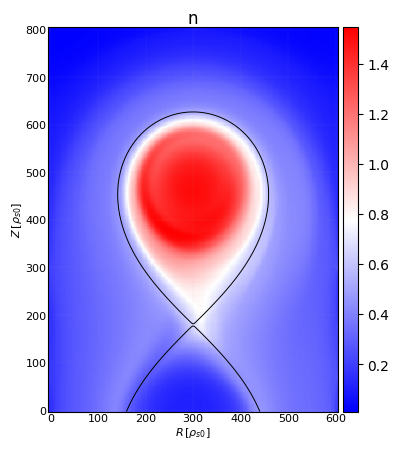

In [33]:
X, Y = np.meshgrid(s.x, s.y)
fig, ax = plt.subplots(figsize=(4, 5), sharex=True, sharey=True)

cs1 = ax.pcolormesh(X, Y, dens_avg, cmap='bwr')
#cs1 = ax.pcolormesh(X, Y, dens_avg, cmap='bwr')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar=fig.colorbar(cs1, cax=cax, orientation='vertical')
cbar.ax.tick_params(labelsize=10)


ax.contour(X, Y, s.Psi, levels=[s.Psi[s.iyxpt, s.ixxpt]], linewidths=0.7, colors='k')
ax.grid(True, which='major', alpha=1., linestyle=':', linewidth=0.1)
ax.grid(True, which='minor', alpha=0.2, linestyle=':', linewidth=0.1)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(axis='x', labelsize=8, pad=1)
ax.tick_params(axis='y', labelsize=8, pad=1)
ax.tick_params(which='minor', direction="in", size=0)
ax.tick_params(which='major', direction="in", size=0)

        
ax.set_xlabel(r'$R \,[\rho_{s0}]$', fontsize=8, labelpad=1)


ax.set_ylabel(r'$Z\, [\rho_{s0}]$', fontsize=8, rotation=90, labelpad=1)

ax.set_title(r'n', fontsize=12, pad=1.5)

#plt.gca().set_aspect('equal')
plt.show(block=False)

In [34]:
import numpy as np

# --------------------------------------------------------------------------------
# 0) Basic inputs from the simulation
# --------------------------------------------------------------------------------
Xxpt = s.xxpt      # X-point R coordinate
Yxpt = s.yxpt      # X-point Z coordinate
xmag = s.x0        # magnetic axis R
ymag = s.y0        # magnetic axis Z

Psi  = s.Psi       # shape (ny, nx)
dens = dens_avg    # same shape as Psi, (ny, nx)
x    = s.x         # R grid, length nx
y    = s.y         # Z grid, length ny

ny, nx = dens.shape

# --------------------------------------------------------------------------------
# 1) Find grid indices near magnetic axis and X-point
# --------------------------------------------------------------------------------
ix_mag = np.argmin(np.abs(x - xmag))
iy_mag = np.argmin(np.abs(y - ymag))

ix_xpt = np.argmin(np.abs(x - Xxpt))
iy_xpt = np.argmin(np.abs(y - Yxpt))

psi_core = Psi[iy_mag, ix_mag]   # flux at magnetic axis
psi_sep  = Psi[iy_xpt, ix_xpt]   # flux at X-point (separatrix)

print("psi_core =", psi_core)
print("psi_sep  =", psi_sep)

# --------------------------------------------------------------------------------
# 2) Build cell-centered grid and cell areas
#    (everything with shape (ny-1, nx-1))
# --------------------------------------------------------------------------------
X_nodes, Y_nodes = np.meshgrid(x, y)  # nodes, (ny, nx)

# cell-centered coordinates
Xc = 0.25 * (X_nodes[:-1, :-1] + X_nodes[1:, :-1] +
             X_nodes[:-1,  1:] + X_nodes[1:,  1:])
Yc = 0.25 * (Y_nodes[:-1, :-1] + Y_nodes[1:, :-1] +
             Y_nodes[:-1,  1:] + Y_nodes[1:,  1:])

# cell-centered Psi and density
Psi_c = 0.25 * (Psi[:-1, :-1] + Psi[1:, :-1] +
                Psi[:-1,  1:] + Psi[1:,  1:])
dens_c = 0.25 * (dens[:-1, :-1] + dens[1:, :-1] +
                 dens[:-1,  1:] + dens[1:,  1:])

# cell areas dR * dZ (non-uniform allowed)
dx = np.diff(x)             # (nx-1,)
dy = np.diff(y)             # (ny-1,)
DX, DY = np.meshgrid(dx, dy)  # (ny-1, nx-1)
cell_area = DX * DY           # 2D area element in (R,Z) plane

# --------------------------------------------------------------------------------
# 3) Define inside vs outside separatrix using Psi
#    Inside = region between psi_core and psi_sep (contains magnetic axis)
# --------------------------------------------------------------------------------
psi_min = min(psi_core, psi_sep)
psi_max = max(psi_core, psi_sep)

inside_mask  = (Psi_c >= psi_min) & (Psi_c <= psi_max)
outside_mask = ~inside_mask

# --------------------------------------------------------------------------------
# 4) Integrals
# --------------------------------------------------------------------------------
# 4a) 2D "volume" per unit toroidal length: ∫ n dR dZ
N2D_inside  = np.sum(dens_c[inside_mask]  * cell_area[inside_mask])
N2D_outside = np.sum(dens_c[outside_mask] * cell_area[outside_mask])

# 4b) 3D toroidal volume integral: ∫ n dV = ∫ n 2π R dR dZ
N3D_inside  = np.sum(dens_c[inside_mask]  * cell_area[inside_mask] * 2.0 * np.pi * Xc[inside_mask])
N3D_outside = np.sum(dens_c[outside_mask] * cell_area[outside_mask] * 2.0 * np.pi * Xc[outside_mask])

print("\n=== Density integrals (single-null) ===")
print("2D (per unit toroidal length):")
print("  Inside separatrix   ∫ n dR dZ  =", N2D_inside)
print("  Outside separatrix  ∫ n dR dZ  =", N2D_outside)

print("\n3D (full torus):")
print("  Inside separatrix   ∫ n dV     =", N3D_inside)
print("  Outside separatrix  ∫ n dV     =", N3D_outside)


psi_core = 107655.80286738301
psi_sep  = 115365.98119056014

=== Density integrals (single-null) ===
2D (per unit toroidal length):
  Inside separatrix   ∫ n dR dZ  = 116448.81187862568
  Outside separatrix  ∫ n dR dZ  = 104698.40885591751

3D (full torus):
  Inside separatrix   ∫ n dV     = 219569872.38281417
  Outside separatrix  ∫ n dV     = 206308832.16491604


psi_core = 107655.80286738301
psi_sep  = 115365.98119056014


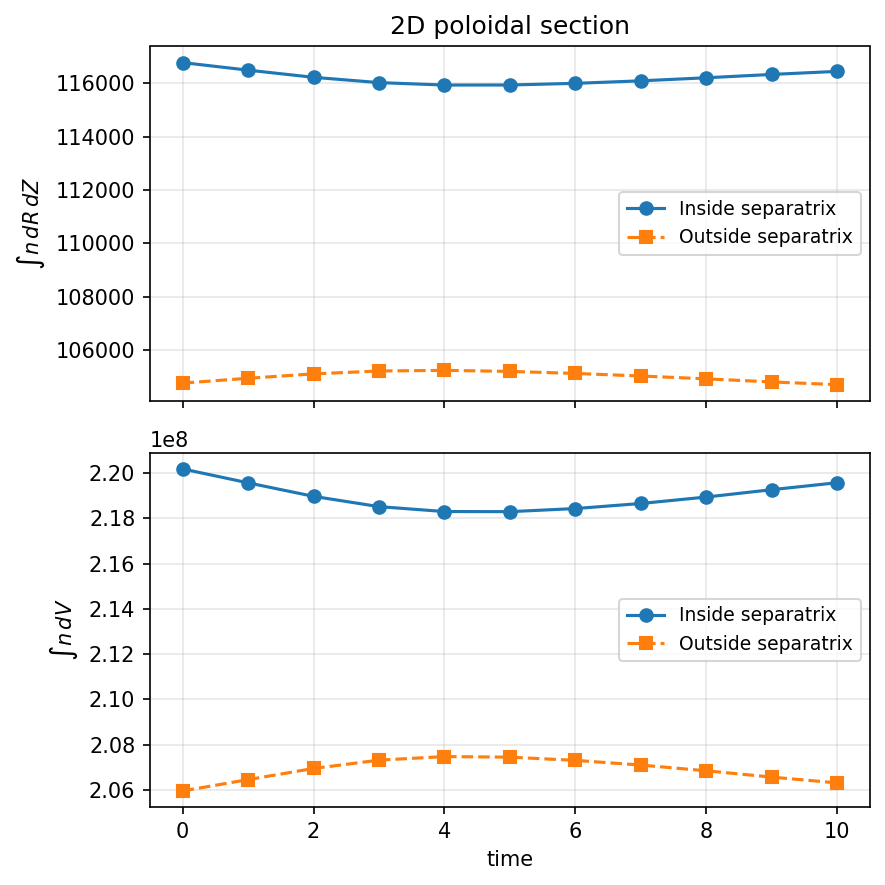

In [41]:
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------
# Basic inputs from simulation
# ---------------------------
Psi  = s.Psi        # shape (ny, nx)
x    = s.x          # R grid, length nx
y    = s.y          # Z grid, length ny

ny, nx = Psi.shape
_, _, nphi, nt = dens.shape

Xxpt = s.xxpt
Yxpt = s.yxpt
xmag = s.x0
ymag = s.y0

# ---------------------------
# 1) Indices for magnetic axis and X-point
# ---------------------------
ix_mag = np.argmin(np.abs(x - xmag))
iy_mag = np.argmin(np.abs(y - ymag))

ix_xpt = np.argmin(np.abs(x - Xxpt))
iy_xpt = np.argmin(np.abs(y - Yxpt))

psi_core = Psi[iy_mag, ix_mag]
psi_sep  = Psi[iy_xpt, ix_xpt]

print("psi_core =", psi_core)
print("psi_sep  =", psi_sep)

# ---------------------------
# 2) Cell-centered geometry (time-independent)
# ---------------------------
X_nodes, Y_nodes = np.meshgrid(x, y)  # (ny, nx)

Xc = 0.25 * (X_nodes[:-1, :-1] + X_nodes[1:, :-1] +
             X_nodes[:-1,  1:] + X_nodes[1:,  1:])
Yc = 0.25 * (Y_nodes[:-1, :-1] + Y_nodes[1:, :-1] +
             Y_nodes[:-1,  1:] + Y_nodes[1:,  1:])

Psi_c = 0.25 * (Psi[:-1, :-1] + Psi[1:, :-1] +
                Psi[:-1,  1:] + Psi[1:,  1:])

dx = np.diff(x)           # (nx-1,)
dy = np.diff(y)           # (ny-1,)
DX, DY = np.meshgrid(dx, dy)    # (ny-1, nx-1)
cell_area = DX * DY            # dR dZ

# Separatrix mask (inside between core and X-point)
psi_min = min(psi_core, psi_sep)
psi_max = max(psi_core, psi_sep)

inside_mask  = (Psi_c >= psi_min) & (Psi_c <= psi_max)
outside_mask = ~inside_mask

# ---------------------------
# 3) Time evolution of integrals
# ---------------------------
N2D_inside  = np.zeros(nt)
N2D_outside = np.zeros(nt)
N3D_inside  = np.zeros(nt)
N3D_outside = np.zeros(nt)

for it in range(nt):
    # Average over toroidal direction -> 2D (ny, nx)
    dens_t2D = dens[:, :, :, it].mean(axis=2)

    # Cell-centered density at this time
    dens_c = 0.25 * (dens_t2D[:-1, :-1] + dens_t2D[1:, :-1] +
                     dens_t2D[:-1,  1:] + dens_t2D[1:,  1:])

    # 2D integrals (per unit toroidal length)
    N2D_inside[it]  = np.sum(dens_c[inside_mask]  * cell_area[inside_mask])
    N2D_outside[it] = np.sum(dens_c[outside_mask] * cell_area[outside_mask])

    # 3D toroidal integrals: ∫ n dV = ∫ n 2π R dR dZ
    N3D_inside[it]  = np.sum(dens_c[inside_mask]  * cell_area[inside_mask] * 2.0 * np.pi * Xc[inside_mask])
    N3D_outside[it] = np.sum(dens_c[outside_mask] * cell_area[outside_mask] * 2.0 * np.pi * Xc[outside_mask])

# ---------------------------
# 4) Time axis
# ---------------------------
# If you have a time array from the simulation, use that instead:
# t = s.t  # or whatever your time array is
t = np.arange(nt)   # fallback: 0, 1, ..., nt-1

# ---------------------------
# 5) Plot time evolution
# ---------------------------
fig, axes = plt.subplots(2, 1, figsize=(6, 6), dpi=150, sharex=True)

# 2D integrals
axes[0].plot(t, N2D_inside,  'o-', label='Inside separatrix')
axes[0].plot(t, N2D_outside, 's--', label='Outside separatrix')
axes[0].set_ylabel(r'$\int n \, dR \, dZ$')
axes[0].legend(loc='best', fontsize=9)
axes[0].grid(True, alpha=0.3)
axes[0].set_title('2D poloidal section')

# 3D integrals
axes[1].plot(t, N3D_inside,  'o-', label='Inside separatrix')
axes[1].plot(t, N3D_outside, 's--', label='Outside separatrix')
axes[1].set_xlabel('time')
axes[1].set_ylabel(r'$\int n \, dV$')
axes[1].legend(loc='best', fontsize=9)
axes[1].grid(True, alpha=0.3)
axes[1]

plt.tight_layout()
plt.show()
